In [ ]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
!gdown --id 1Z00gxGeosvgrzGITGTFotZJnJK6U2GF4

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Z00gxGeosvgrzGITGTFotZJnJK6U2GF4
To: /content/train.csv
100% 461k/461k [00:00<00:00, 61.9MB/s]


In [ ]:
train = pd.read_csv('/content/train.csv')
train = train[['LotArea','SalePrice']].head(20)

In [ ]:
train

,LotArea,SalePrice
0,8450,208500
1,9600,181500
2,11250,223500
3,9550,140000
4,14260,250000
5,14115,143000
6,10084,307000
7,10382,200000
8,6120,129900
9,7420,118000


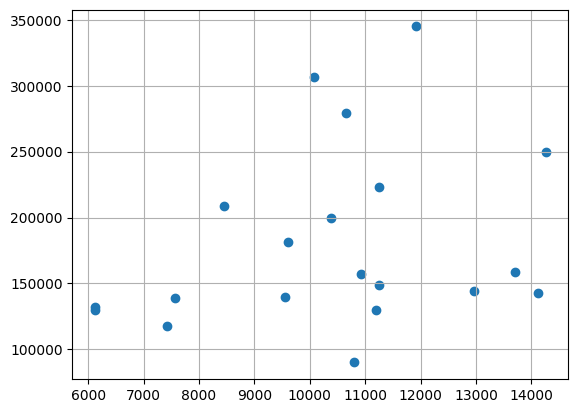

In [ ]:
plt.grid(True)
plt.scatter(train['LotArea'],train['SalePrice'])
plt.show()

# Gradient boosting

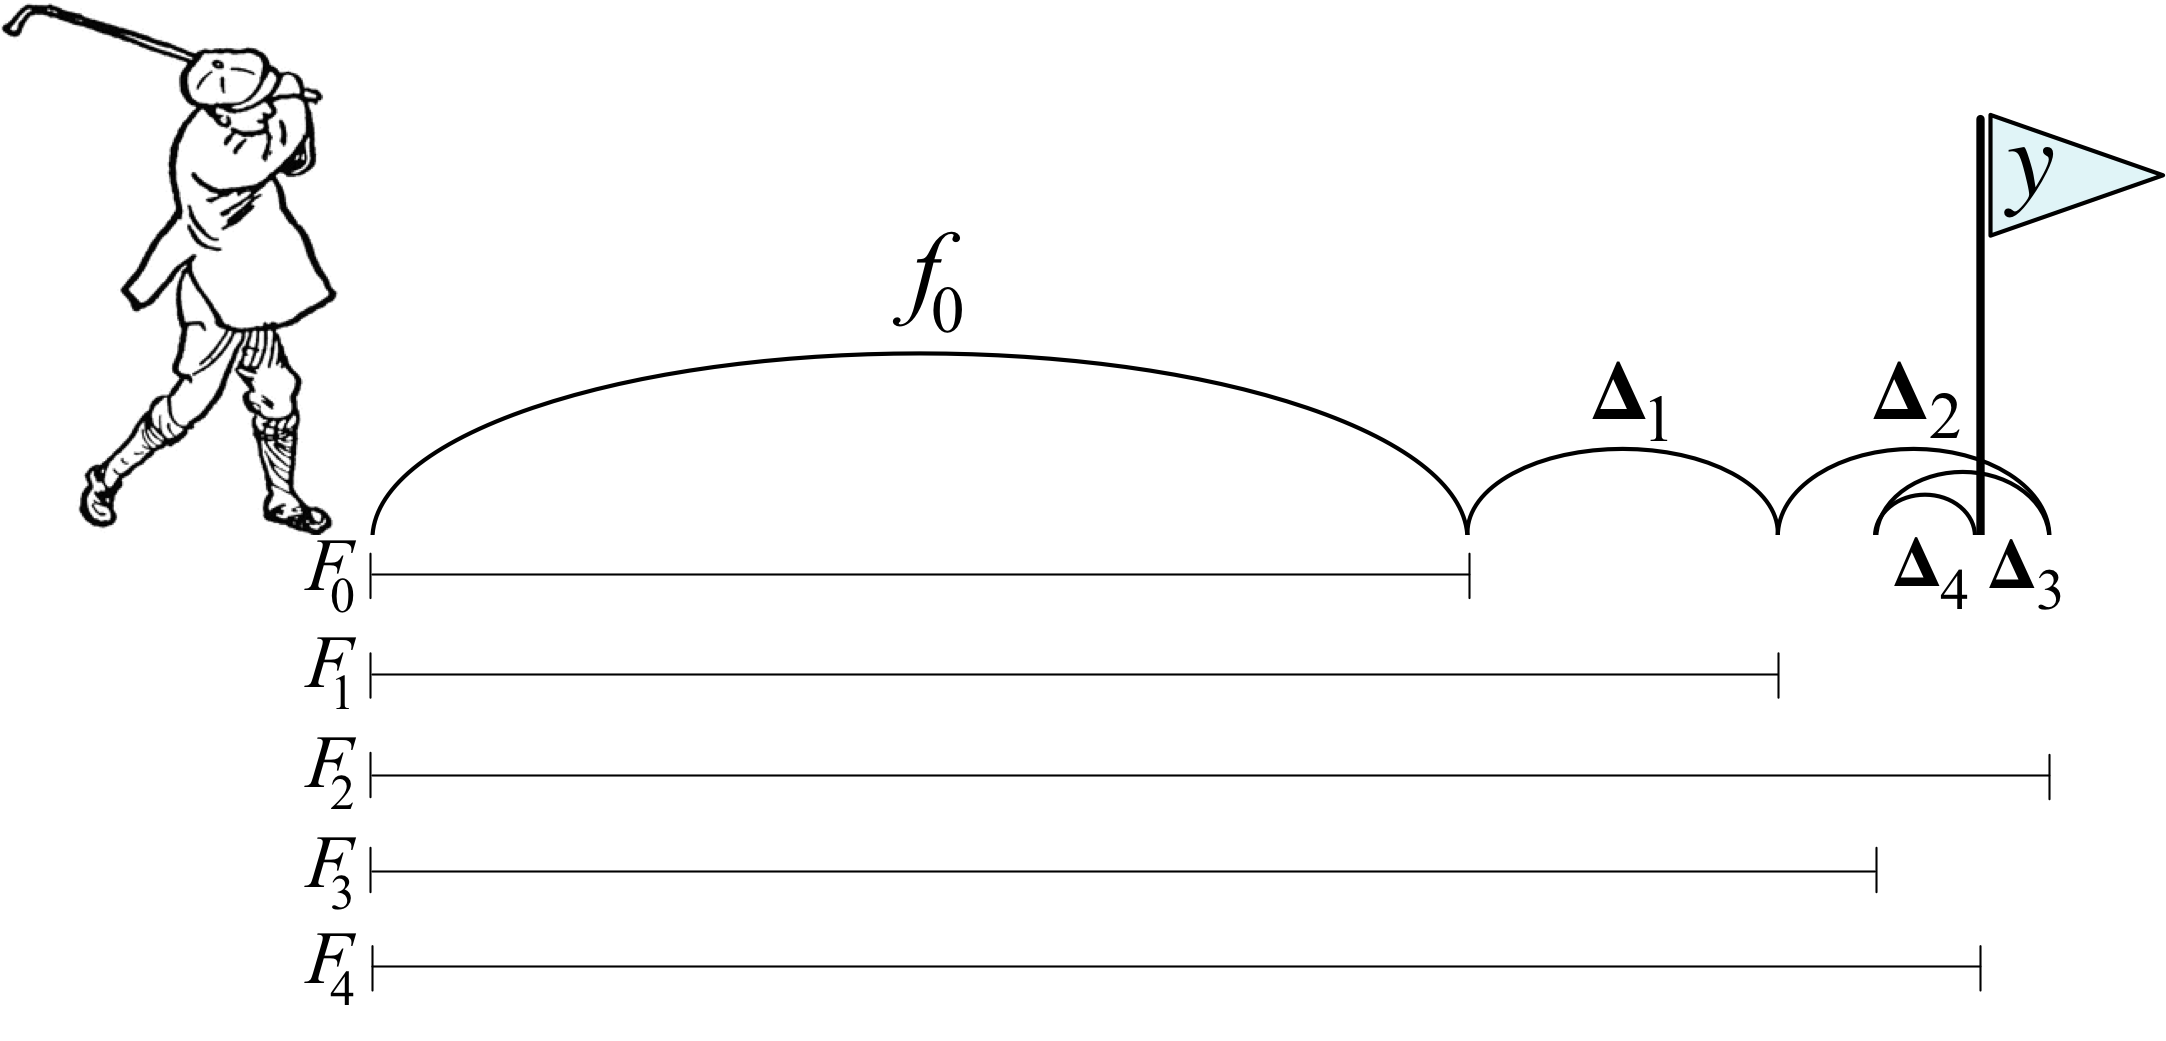

ИСТОЧНИК - https://explained.ai/gradient-boosting/L2-loss.html

## Интуиция

Бустинг объединяет простые модели в одну сложную, каждый раз учитывая ошибки прошлой модели, минимизируя ее.

Первый прогноз - это среднее всех цен на жилье, далее вычтим предсказание (это среднее) из реальных цен и посомотрим на ошибку.

## Инициалзация и первый шаг

Градиентный бустинг итеративно объединяет слабые модели $F_1(x) + \dots + F_k(x) = a(x)$, уточняя ошибки $R_i^1 = y_i - F_1(x_i)$ предыдущей модели $F_{i-1}$. Первая модель грубо приближает истинную зависимость, а каждая последующая уточняет её, делая приближение всё точнее.

Это достигается с помощью оптимизации дифференцируемой функции потерь, например, среднеквадратичной ошибки:
$ L(x,y) = \frac{1}{n} \sum_{i=1}^n \left( y_i - \hat{y}_i \right)^2 \rightarrow \min
$

Если алгоритм состоит из $N$ итераций $(1 \leq n \leq N)$, на каждой итерации алгоритм добавляет новую оценку:  
$F_n(x_i) = F_{n-1}(x_i) + R_n(x_i)$

или

$R_n(x_i) = y_i -  F_{n-1}(x_i)$

Таким образом мы корректиируем $F_1$, используя $F_2$:

$F_n(x_i) =  F_{n-1}(x_i) + ( y_i -  F_{n-1}(x_i))= y_i$

$b_n(x) = \underset{b \in B}{\arg \min} L(R_{n-1}, F(x))
$

Fредставьте, что у нас есть данные о площади 20 квартир и их стоимости в качестве обучающих данных:


Давайте используем среднеезначение стоимости в качестве нашей начальной модели:
$F_1 = \bar{y}$

In [ ]:
train['pred_1'] = train['SalePrice'].mean()
train['residual'] = train['SalePrice'] - train['pred_1']

print('MSE=',mse(train['SalePrice'],train['pred_1']))

MSE= 4420700100.0


Для следущего обучения некоторая простая модель, в нашем случае это пень (дерево с глубиной = 1 ) будет учитывать новую оценку residual = $R$

Таким образом: $Fₒ₊₁=Fₒ(xᵢ)+Rₒ(xᵢ)=yᵢ$

In [ ]:
 tree = DecisionTreeRegressor(random_state=0, max_depth=1)
tree.fit(train[['LotArea']], train[['residual']])
train['pred_2'] = train['pred_1'] + 1*tree.predict(train[['LotArea']])

print('MSE=',mse(train['SalePrice'],train['pred_2']))

MSE= 3756478343.75


In [ ]:
mse_better = ((mse(train['SalePrice'],train['pred_1'])-
               mse(train['SalePrice'],train['pred_2']))/
              mse(train['SalePrice'],train['pred_2'])*100)

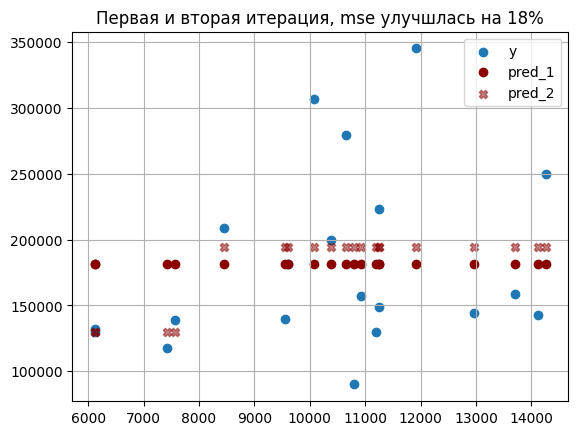

In [ ]:
plt.grid(True)
plt.scatter(train['LotArea'],train['SalePrice'], label='y')
plt.scatter(train['LotArea'],train['pred_1'],color='#8B0000', alpha=1, label='pred_1')
plt.scatter(train['LotArea'],train['pred_2'],color='#8B0000',alpha=0.5, label='pred_2', marker='X')
plt.title(f'Первая и вторая итерация, mse улучшлась на {round(mse_better)}%')
plt.legend()
plt.show()

In [ ]:
predictions_dict = {}
n_iterations = 1000

def g_boosting(n_iterate=n_iterations, learning_rate=0.1):
    train['pred_1'] =  0  # Начальная инициализация предсказаний
    train['pred_0'] = 0

    for i in range(n_iterations):
        # Вычисляем остатки (градиенты)
        train['residual'] = train['SalePrice'] - train['pred_1']

        # Обучаем дерево на остатках
        tree = DecisionTreeRegressor(random_state=0, max_depth=1)
        tree.fit(train[['LotArea']], train['residual'])

        # Обновляем предсказания
        train['pred_1'] += learning_rate * tree.predict(train[['LotArea']])

        # Сохраняем прогнозы текущей итерации
        predictions_dict[i + 1] = train['pred_1'].copy()
    #return predictions_dict

    # Визуализация предсказаний
    plt.figure(figsize=(10, 6))
    plt.scatter(train['LotArea'], train['SalePrice'], label='Истинные значения цены', alpha=0.85)

    for i in range(1, n_iterations + 1):
        alpha = 0.3
        plt.scatter(train['LotArea'], predictions_dict[i], alpha=alpha, color='r', marker="|")

    MSE =  mse(train['SalePrice'],predictions_dict[n_iterations])

    # Итоговые предсказания
    plt.scatter(train['LotArea'], predictions_dict[n_iterations], color='r', marker="x", alpha=0.5, label='Итоговые предсказания')
    plt.scatter(train['LotArea'], train['pred_0'], color='r', marker="2", alpha=1, label='начальное предсказание =0')
    plt.xlabel('LotArea')
    plt.ylabel('SalePrice')
    plt.title(f'Эволюция предсказаний с градиентным бустингом. MSE в последней итерации={round(MSE)}')
    plt.title(f'Кол-во итераций = {n_iterations}')
    plt.legend()
    plt.show()

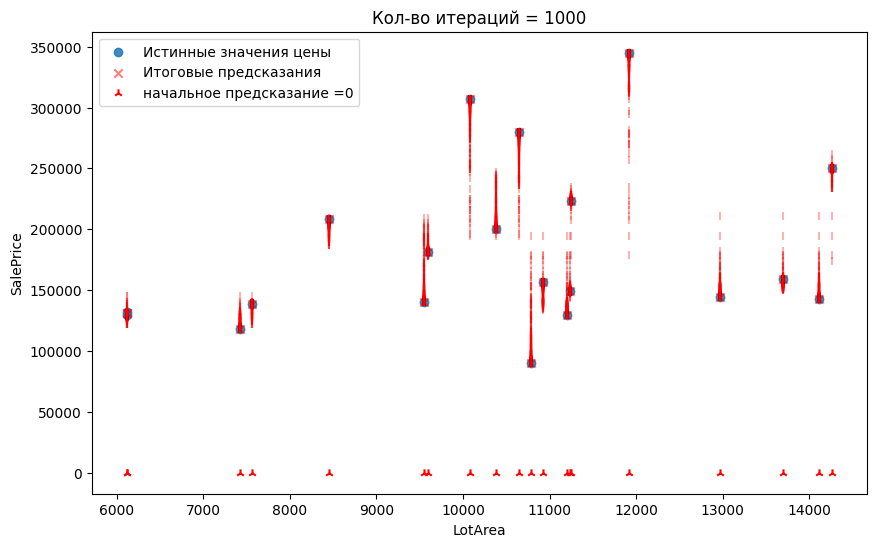

In [ ]:
g_boosting(_, 1)

In [ ]:
gbr = GradientBoostingRegressor(
    n_estimators=1000,        # Число итераций (деревьев)
    learning_rate=1,       # Скорость обучения
    max_depth=1,             # Глубина деревьев
    loss='squared_error',    # Функция потерь
    random_state=0,          # Для воспроизводимости
    subsample=1.0,           # Используем все данные (без подвыборок)
    min_samples_split=2,     # Минимум 2 примера для разбиения
    min_samples_leaf=1       # Минимум 1 пример в каждом листе
)
gbr.fit(train[['LotArea']], train['SalePrice'])

GradientBoostingRegressor(learning_rate=1, max_depth=1, n_estimators=1000,
                          random_state=0)

In [ ]:
diff = pd.DataFrame(predictions_dict[1000])
diff['pred_gbr'] =  gbr.predict(train[['LotArea']])
diff['SalePrice'] = train['SalePrice']
diff

,pred_1,pred_gbr,SalePrice
0,208497.904790,208497.904790,208500
1,181499.954996,181499.954996,181500
2,223502.312143,223502.312143,223500
3,140002.148679,140002.148679,140000
4,249999.498493,249999.498493,250000
5,143000.573909,143000.573909,143000
6,306997.980836,306997.980836,307000
7,200002.106208,200002.106208,200000
8,130949.764098,130949.764098,129900
9,118001.624484,118001.624484,118000


In [ ]:
predictions_dict[n_iterations]

,pred_1
0,208497.904790
1,181499.954996
2,223502.312143
3,140002.148679
4,249999.498493
5,143000.573909
6,306997.980836
7,200002.106208
8,130949.764098
9,118001.624484


In [ ]:
mse(diff['pred_gbr'],diff['pred_gbr'])

0.0